# Sex Associated Contigs


In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
from tqdm import tqdm
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.feature_selection import f_regression
from sklearn import metrics
colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
F_REGRESSION_RESULTS = BLOOD_MICROBIOME_DIR + 'results/f_regression/f_regression_results.csv'
BAM_MAPPINGS_FILE = BLOOD_MICROBIOME_DIR + 'data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)

MICROBE_FILE = BLOOD_MICROBIOME_DIR + 'data/kraken_align/microbe_filtered_species.tsv'
FIG_DIR = BLOOD_MICROBIOME_DIR + 'results/y_chrom_association'
TAX_IDS_TO_GREP_FILE = BLOOD_MICROBIOME_DIR + 'results/y_chrom_association/tax_ids_to_grep.txt'
TAX_NAMES_TO_GREP_FILE = BLOOD_MICROBIOME_DIR + 'results/y_chrom_association/tax_names_to_grep.txt'

df_microbe = pd.read_table(MICROBE_FILE, index_col=0).transpose()

# Get y associated contigs.

In [2]:
f_regress_results = pd.read_csv(F_REGRESSION_RESULTS, header=None)
f_regress_results.drop(0, inplace=True, axis=1)
f_regress_results.columns = ['name', 'exog_value', 'coeff']
f_regress_results['coeff_abs'] = abs(f_regress_results.coeff)

In [3]:
y_associated_contigs = f_regress_results[f_regress_results.exog_value=='sex_numeric_2.0'].sort_values(
    'coeff_abs', ascending=False)
y_associated_contigs = y_associated_contigs[y_associated_contigs.coeff<0][['name']].drop_duplicates().name.values
y_associated_contigs


x_associated_contigs = f_regress_results[f_regress_results.exog_value=='sex_numeric_2.0'].sort_values(
    'coeff_abs', ascending=False)
x_associated_contigs = x_associated_contigs[x_associated_contigs.coeff>0][['name']].drop_duplicates().name.values

In [4]:
taxonomies = pd.read_csv('/home/groups/dpwall/briannac/blood_microbiome/data/kraken_align/taxonomies.tsv', sep='\t', header=None)
taxonomies.columns = ['frac', 'n', '2', 'tax_level', 'tax_id', 'tax_name']
taxonomies.tax_name = [''.join(n[np.where(np.array(list(n))!=' ')[0][0]:]) for n in taxonomies.tax_name]

In [5]:
y_taxonomies = taxonomies[[n in y_associated_contigs for n in taxonomies.tax_name]]
y_taxonomies = y_taxonomies[y_taxonomies.tax_id!=9606]

In [21]:
with open(TAX_IDS_TO_GREP_FILE, 'w') as f:
    for i in [r"kraken:taxid%s$" % str(t)  for t in y_taxonomies.tax_id]:
        f.write(i + '\n')
with open(TAX_NAMES_TO_GREP_FILE, 'w') as f:
    for i in [r"(taxid %s)" % str(t)  for t in y_taxonomies.tax_id]:
        f.write(i + '\n')
        
##kraken:tax_id\|1560339$
#kraken:tax_id\|28901$

In [3]:
kraken_classes = pd.read_table(
    '/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/y_chrom_association/all.tsv',
    header=None)
kraken_classes.columns = ['sample', 'read_id', 'tax_id', 'seq', 'read_id_dup', 'tax_name', 'kmer_length', 'kmer_classes']
kraken_classes.drop(['read_id_dup', 'kmer_length'], inplace=True, axis=1)

In [4]:
kraken_classes.columns = ['sample', 'read_id', 'tax_id', 'seq', 'read_id_dup', 'tax_name', 'kmer_length', 'kmer_classes']
kraken_classes.drop(['read_id_dup', 'kmer_length'], inplace=True, axis=1)

In [20]:
Counter(kraken_classes.tax_id).most_common(20)

[(28901, 4463299),
 (1653831, 1705889),
 (1560339, 1504768),
 (446, 618201),
 (336810, 514723),
 (28450, 458685),
 (1313, 431869),
 (630, 385493),
 (454, 367113),
 (9, 323836),
 (2731756, 260955),
 (362837, 155333),
 (1742359, 146628),
 (2675773, 113866),
 (164514, 92552),
 (96345, 90484),
 (1491, 82878),
 (1502, 62466),
 (1922217, 61960),
 (2683967, 58429)]

In [171]:
tax_id = 1278232
df_pivot = pd.pivot_table(kraken_classes[kraken_classes.tax_id>336810].groupby(['seq', 'sample']).count()[['read_id']].reset_index(), values='read_id', index='seq', columns='sample')
df_pivot[pd.isna(df_pivot)]=0
df_pivot['mean'] = df_pivot.mean(axis=1)

In [161]:
df_pivot.sort_values('mean', ascending=False).iloc[:10]

sample,02C10540,02C10541,02C10542,02C10543,02C10702,02C10704,02C10855,02C10856,02C10857,02C10858,...,02C12260,02C12341,02C12342,02C12343,02C12344,02C12373,02C12374,02C12376,02C12627,mean
seq,,,,,,,,,,,,,,,,,,,,,
TTATATATAACTGTATAATATTTTATGTAAATATGTAATATAATATATATAACTATATAATATATTATATATAACTATATATTATGTTATATATACTTTTATAACATAATTTACATAAAATATCATAATATAATATATATTATATTATTTA,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,5.0,...,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.686869
TGGGTGATATGTAATATATATTATGTAATATGAAATAATATAATATATATTATATTATGATATTTTATGTAAATTATGTTATAAAAGTATATATAACATAATATATAGTTATATATAATATATTATATAGTTATATATATTATATTATATA,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.787879
AACTGTATAATATTTTATGTAAATATGTAATATAATATATATAACTATATAATATATTATATATAACTATATATTATGTTATATATACTTTTATAACATAATTTACATAAAATATCATAATATAATATATATTATATTATTTTATATTACA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,...,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.767677
TATATGTTTTATATTCTGTTATATATAACTATTTGAAATTATATATAACTGTATAATATTTTATGTAAATATGTAATATAATATATATAACTATATAATATATTATATATAACTATATATTATGTTATATATACTTTTATAATATAATTTA,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707071
TAATATGAAATAATATAATATATATTATATTATGATATTTTATGTAAATTATGTTATAAAAGTATATATAACATAATATATAGTTATATATAATATATTATATAGTTATATATATTATATTACATATTTACATAAAATATTATAAAGTTAT,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.696970
TATATGTTTTATATTCTGTTATATATAACTATTTGAAATTATATATAACTGTATAATATTTTATGTAAATATGTAATATAATATATATAACTATATAATATATTATATATAACTATATATTATGTTATATATACTTTTATAAAATAATTTA,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,...,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.606061
GACATTTTATGTAAATTATGTTATAAAAGTATATATAACATAATATATAGTTATATATAATATATTATATAGTTATATATATTATATTACATATTTACATAAAATATTATACAGTTATATATAATTTCAAATAGTTATATATAACAGAATA,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.565657
TATTCTGTTATATATAACTATTTGAAATTATATATAACTGTATAATATTTTATGTAAATATGTAATATAATATATATAACTATATAATATATTATATATAACTATATATTATGTTATATATACTTTTATAACATAATTTACATAAAATGTC,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556
TCTATATGTTATATATTCTGTTATATATAACTGTTTGAAATTATATATAACTGTATAATATTTTAGGTAAATATGTAATATAATATATATAACTTTATAATATATTATATATAACTATATATTATGTTATATATACTTTTATAACATAATT,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505051


In [172]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = df_pivot.drop('mean',  axis=1).transpose()
pca = PCA(n_components=100)


In [167]:
s = StandardScaler()
s.fit(X[(bam_mappings.loc[X.index]['sex_numeric']=='2.0').values])
X_norm = s.transform(X[(bam_mappings.loc[X.index]['sex_numeric']=='2.0').values])
pca.fit(X[(bam_mappings.loc[X.index]['sex_numeric']=='2.0').values])
transform = pd.DataFrame(pca.transform(X))
#transform_females = transform[(bam_mappings.loc[X.index]['sex_numeric']=='2.0').values]
#transform_males = transform[(bam_mappings.loc[X.index]['sex_numeric']=='1.0').values]

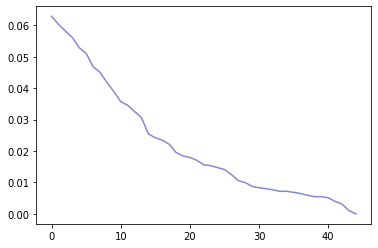

In [169]:
plt.plot(pca.explained_variance_ratio_)

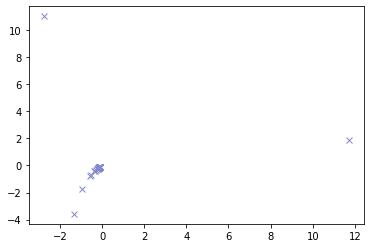

In [170]:
plt.plot(transform[0], transform[1], 'x')

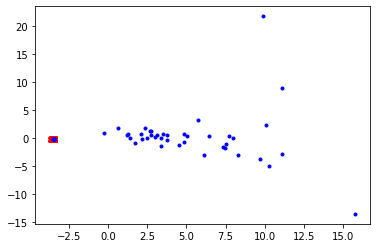

In [153]:
plt.plot(transform_females[0], transform_females[1], 'rX')
plt.plot(transform_males[0], transform_males[1], 'b.')


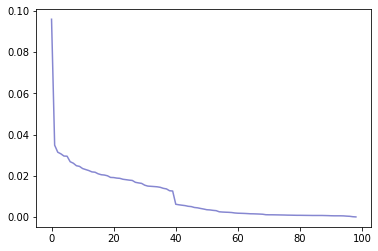

In [154]:
plt.plot(pca.explained_variance_ratio_)

In [124]:
sum(pca.explained_variance_ratio_)

1.0000000000000002

In [40]:
bam_mappings.loc['02C12373'][['sex_numeric', 'family', 'relationship']]

sex_numeric        1.0
family          AU0866
relationship    father
Name: 02C12373, dtype: object

In [166]:
kmers = kraken_classes[['sample', 'tax_id', 'kmer_classes_list']].groupby(['sample']).aggregate(lambda x:Counter([i for j in list(x) for i in j]).most_common())

In [173]:
kmers.kmer_classes_list[0][0]

('ATTTTATAACATATGTAATATATATTATATATTAT', 10816)

In [125]:
def KrakenToKmers(row):
    kraken_format_out = row['kmer_classes']
    desired_tax_id  = str(row['tax_id'])
    seq  = row['seq']
    
    tax_ids_n_seqs = [(i.split(':')[0],int(i.split(':')[1])) for i in  (kraken_format_out+ ' ').split(' ') if i!='']
    i = 0
    a = []
    for tax_id, n_seq in tax_ids_n_seqs:
        if tax_id == desired_tax_id:
            a = a + [seq[(i+s):(i+s+35)]for s in range(n_seq)]
        i = i + n_seq
    return a

kraken_classes['kmer_classes_list'] = kraken_classes.apply(KrakenToKmers, axis=1)